In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from autoencoder import autoencoder
from tensorflow.keras.datasets import mnist
from clusteringlayer import ClusteringLayer
from tensorflow.keras.initializers import VarianceScaling
from sklearn.utils.linear_assignment_ import linear_assignment

/home/tanmay/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [2]:
sns.set(font_scale = 3)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [4]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale = 1. / 3., mode = 'fan_in',
                           distribution = 'uniform')
pretrain_optimizer = tf.keras.optimizers.SGD(lr = 1, momentum = 0.9)
pretrain_epochs = 30
batch_size = 256

In [5]:
autoencoder, encoder = autoencoder(dims, init = init)

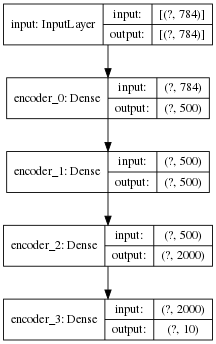

In [6]:
tf.keras.utils.plot_model(encoder, show_shapes = True, dpi = 64)

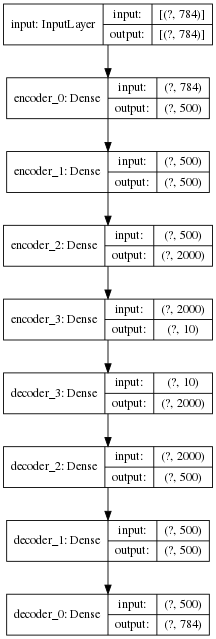

In [7]:
tf.keras.utils.plot_model(autoencoder, show_shapes = True, dpi = 64)

In [8]:
autoencoder.compile(optimizer = pretrain_optimizer, loss = 'mse')
autoencoder.fit(x, x, batch_size = batch_size, epochs = pretrain_epochs, verbose = 2)

Epoch 1/30
274/274 - 1s - loss: 0.0652
Epoch 2/30
274/274 - 1s - loss: 0.0437
Epoch 3/30
274/274 - 1s - loss: 0.0314
Epoch 4/30
274/274 - 1s - loss: 0.0265
Epoch 5/30
274/274 - 1s - loss: 0.0240
Epoch 6/30
274/274 - 1s - loss: 0.0224
Epoch 7/30
274/274 - 1s - loss: 0.0212
Epoch 8/30
274/274 - 1s - loss: 0.0202
Epoch 9/30
274/274 - 1s - loss: 0.0195
Epoch 10/30
274/274 - 1s - loss: 0.0189
Epoch 11/30
274/274 - 1s - loss: 0.0184
Epoch 12/30
274/274 - 1s - loss: 0.0179
Epoch 13/30
274/274 - 1s - loss: 0.0175
Epoch 14/30
274/274 - 1s - loss: 0.0172
Epoch 15/30
274/274 - 1s - loss: 0.0169
Epoch 16/30
274/274 - 1s - loss: 0.0165
Epoch 17/30
274/274 - 1s - loss: 0.0163
Epoch 18/30
274/274 - 1s - loss: 0.0160
Epoch 19/30
274/274 - 1s - loss: 0.0158
Epoch 20/30
274/274 - 1s - loss: 0.0156
Epoch 21/30
274/274 - 1s - loss: 0.0154
Epoch 22/30
274/274 - 1s - loss: 0.0152
Epoch 23/30
274/274 - 1s - loss: 0.0151
Epoch 24/30
274/274 - 1s - loss: 0.0149
Epoch 25/30
274/274 - 1s - loss: 0.0147
Epoch 26/

In [9]:
clustering_layer = ClusteringLayer(10, name = 'clustering')(encoder.output)
model = tf.keras.models.Model(inputs = encoder.input, outputs = clustering_layer)

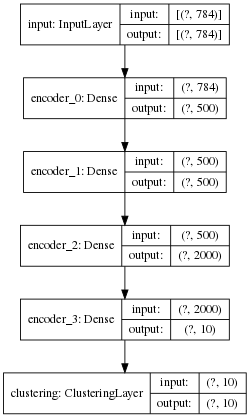

In [10]:
tf.keras.utils.plot_model(model, show_shapes = True, dpi = 64)

In [11]:
model.compile(optimizer = tf.keras.optimizers.SGD(0.01, 0.9), loss = 'kld')

In [12]:
#  initialize cluster centers using k-means
kmeans = KMeans(n_clusters = 10, n_init = 20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [13]:
y_pred_last = np.copy(y_pred)

In [14]:
model.get_layer(name = 'clustering').set_weights([kmeans.cluster_centers_])

In [15]:
# Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [16]:
loss = 0
index = 0
maxiter = 6000
update_interval = 140
index_array = np.arange(x.shape[0])

In [17]:
tol = 0.001

In [18]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose = 0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.accuracy_score(y, y_pred), 5)
            nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
            ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x = x[idx], y = p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Iter 0: acc = 0.18509, nmi = 0.70151, ari = 0.64530  ; loss= 0
Iter 140: acc = 0.18611, nmi = 0.71192, ari = 0.65680  ; loss= 0.04736
Iter 280: acc = 0.18840, nmi = 0.72474, ari = 0.66939  ; loss= 0.14526
Iter 420: acc = 0.18791, nmi = 0.73749, ari = 0.68140  ; loss= 0.20326
Iter 560: acc = 0.18911, nmi = 0.74746, ari = 0.69219  ; loss= 0.22659
Iter 700: acc = 0.18933, nmi = 0.75447, ari = 0.69984  ; loss= 0.22712
Iter 840: acc = 0.18917, nmi = 0.75969, ari = 0.70521  ; loss= 0.22316
Iter 980: acc = 0.18933, nmi = 0.76352, ari = 0.70919  ; loss= 0.22067
Iter 1120: acc = 0.19030, nmi = 0.76724, ari = 0.71345  ; loss= 0.22029
Iter 1260: acc = 0.19097, nmi = 0.77023, ari = 0.71644  ; loss= 0.21185
Iter 1400: acc = 0.19140, nmi = 0.77274, ari = 0.72020  ; loss= 0.20478
Iter 1540: acc = 0.19207, nmi = 0.77422, ari = 0.72157  ; loss= 0.20217
Iter 1680: acc = 0.19193, nmi = 0.77601, ari = 0.72446  ; loss= 0.19043
Iter 1820: acc = 0.19180, nmi = 0.77701, ari = 0.72434  ; loss= 0.19618
Iter 196

In [19]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.accuracy_score(y, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.19121, nmi = 0.78195, ari = 0.73059  ; loss= 0.119


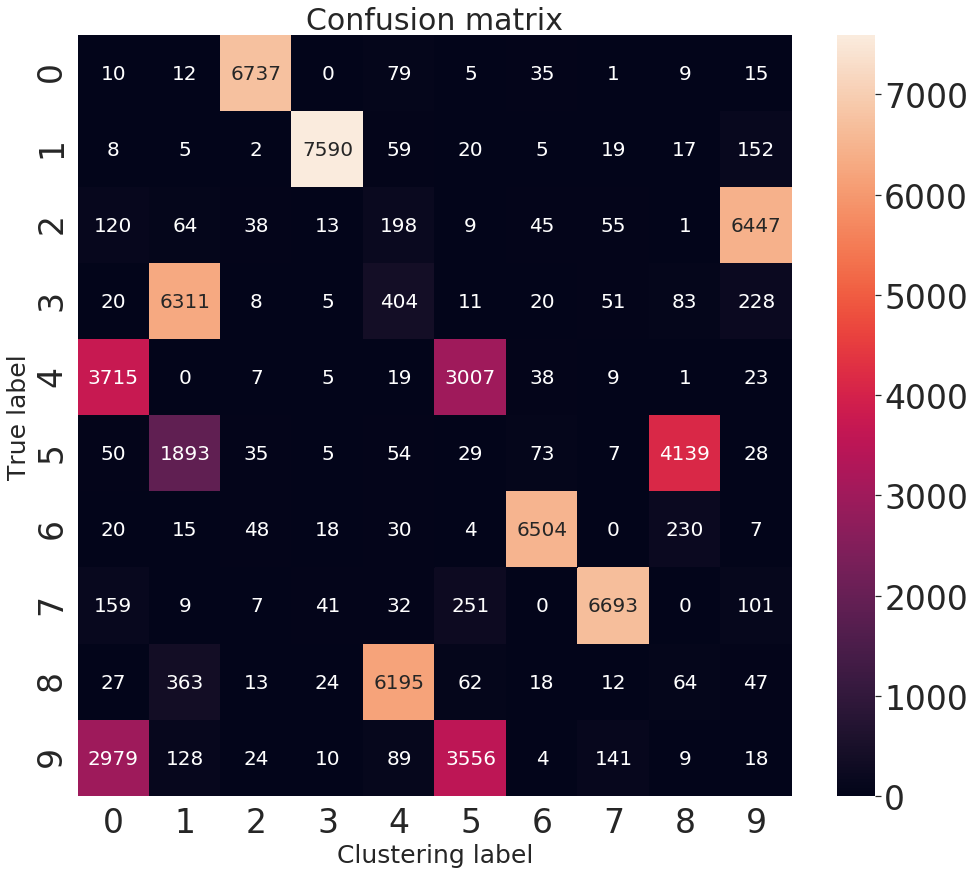

In [20]:
confusion_matrix = metrics.confusion_matrix(y, y_pred)

plt.figure(figsize = (16, 14))
sns.heatmap(confusion_matrix, annot = True, fmt = "d", annot_kws = {"size": 20});
plt.title("Confusion matrix", fontsize = 30)
plt.ylabel('True label', fontsize = 25)
plt.xlabel('Clustering label', fontsize = 25)
plt.show()

In [21]:
# linear assignment- Munkres' Assignment Algorithm


y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/home/tanmay/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.8269571428571428

In [22]:
w

array([[  10,    8,  120,   20, 3715,   50,   20,  159,   27, 2979],
       [  12,    5,   64, 6311,    0, 1893,   15,    9,  363,  128],
       [6737,    2,   38,    8,    7,   35,   48,    7,   13,   24],
       [   0, 7590,   13,    5,    5,    5,   18,   41,   24,   10],
       [  79,   59,  198,  404,   19,   54,   30,   32, 6195,   89],
       [   5,   20,    9,   11, 3007,   29,    4,  251,   62, 3556],
       [  35,    5,   45,   20,   38,   73, 6504,    0,   18,    4],
       [   1,   19,   55,   51,    9,    7,    0, 6693,   12,  141],
       [   9,   17,    1,   83,    1, 4139,  230,    0,   64,    9],
       [  15,  152, 6447,  228,   23,   28,    7,  101,   47,   18]])

In [23]:
ind

array([[0, 4],
       [1, 3],
       [2, 0],
       [3, 1],
       [4, 8],
       [5, 9],
       [6, 6],
       [7, 7],
       [8, 5],
       [9, 2]])

In [24]:
w.argmax(1)

array([4, 3, 0, 1, 8, 9, 6, 7, 5, 2])